
**Importing the data from google drive.**

In [1]:
!gdown https://drive.google.com/uc?id=1ueYpFXyMe1RAnbY38gW8vDep1krmgf2O

Downloading...
From: https://drive.google.com/uc?id=1ueYpFXyMe1RAnbY38gW8vDep1krmgf2O
To: /content/query_result_2000.993493Z.parquet
100% 379k/379k [00:00<00:00, 50.8MB/s]


Installing the required libraries

In [2]:
!pip install -q fastparquet
!pip install -q transformers[sentencepiece]
!pip install -q datasets

In [43]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import nltk
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from statistics import mode,median,mean
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from transformers import AutoTokenizer, DataCollatorWithPadding, TFAutoModelForSequenceClassification
from datasets import Dataset,load_metric
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import classification_report

**Reading the data in the dataframe using pandas**

In [4]:
df = pd.read_parquet("/content/query_result_2000.993493Z.parquet",engine = 'fastparquet')

In [5]:
df.head()

,title,paragraph,news_list,event_timestamp
0,Will the Covid-19 Grinch cancel a Santa rally ...,OPINION: Stock markets typically trade higher ...,"[""Supplier Market""]",2021-12-20T12:34:00Z
1,SPDR S&P XOP ETF In A Multi-Year Uptrend; Buy ...,SPDR S&P Oil & Gas Exploration & Production ET...,"[""Financial Health""]",2021-12-20T12:31:00Z
2,"Britain reports 10,000 new Omicron cases, ‘maj...",The total number of Omicron cases recorded acr...,"[""Environmental""]",2021-12-20T12:31:00Z
3,Risk aversion sentiment continues to percolate,- Risk aversion sentiment on rapid spread of t...,"[""Commodities""]",2021-12-20T12:30:00Z
4,Omicron rush on boosters may make it harder to...,Countries are saying three vaccine doses are n...,"[""Commodities""]",2021-12-20T12:16:00Z


**General EDA**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            2000 non-null   object
 1   paragraph        2000 non-null   object
 2   news_list        2000 non-null   object
 3   event_timestamp  2000 non-null   object
dtypes: object(4)
memory usage: 62.6+ KB


In [7]:
df.isnull().sum()

title              0
paragraph          0
news_list          0
event_timestamp    0
dtype: int64

In [8]:
cat = len(df['news_list'].unique())
print(cat)

6


**EDA for target Variables**

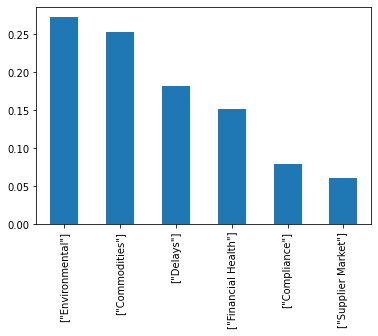

In [9]:
df['news_list'].value_counts(normalize = True).plot.bar()
plt.show()

In [45]:
#Checking Examples 
print("Supplier Market Class Title example :",df[df['news_list']=='["Supplier Market"]']['title'].values[0])
print("Supplier Market Class Paragraph example :",df[df['news_list']=='["Supplier Market"]']['paragraph'].values[0])
print("Financial Health Class Title example :",df[df['news_list']=='["Financial Health"]']['title'].values[0])
print("Financial Health Class Paragraph example :",df[df['news_list']=='["Financial Health"]']['paragraph'].values[0])
print("Environmental Class Title example :",df[df['news_list']=='["Environmental"]']['title'].values[0])
print("Environmental Class Paragraph example :",df[df['news_list']=='["Environmental"]']['paragraph'].values[0])
print("Commodities Class Title example :",df[df['news_list']=='["Commodities"]']['title'].values[0])
print("Commodities Class Paragraph example :",df[df['news_list']=='["Commodities"]']['paragraph'].values[0])
print("Compliance Class Title example :",df[df['news_list']=='["Compliance"]']['title'].values[0])
print("Compliance Class Paragraph example :",df[df['news_list']=='["Compliance"]']['paragraph'].values[0])
print("Delays Class Title example :",df[df['news_list']=='["Delays"]']['title'].values[0])
print("Delays Class Paragraph example :",df[df['news_list']=='["Delays"]']['paragraph'].values[0])

Supplier Market Class Title example : Will the Covid-19 Grinch cancel a Santa rally on the stock markets?
Supplier Market Class Paragraph example : OPINION: Stock markets typically trade higher at this time with a ‘Santa rally’ as investors are typically in an ebullient mood, but Omicron could be the Grinch.
Financial Health Class Title example : SPDR S&P XOP ETF In A Multi-Year Uptrend; Buy The Dips
Financial Health Class Paragraph example : SPDR S&P Oil & Gas Exploration & Production ETF XOP has recently sold off the highs on the back of the new Covid Omicron variant. Check out my trading strategy.
Environmental Class Title example : Britain reports 10,000 new Omicron cases, ‘major incident’ declared in London - National
Environmental Class Paragraph example : The total number of Omicron cases recorded across the country hit almost 25,000 as of 1800 GMT on Friday, up by more than 10,000 cases from 24 hours earlier.
Commodities Class Title example : Risk aversion sentiment continues t

In [11]:
def encoder_funct(df):
    encode_y = LabelEncoder()
    y = encode_y.fit_transform(df['news_list'])
    return y
y = encoder_funct(df)
df['news_list_encoded'] = y

In [12]:
df.head()

,title,paragraph,news_list,event_timestamp,news_list_encoded
0,Will the Covid-19 Grinch cancel a Santa rally ...,OPINION: Stock markets typically trade higher ...,"[""Supplier Market""]",2021-12-20T12:34:00Z,5
1,SPDR S&P XOP ETF In A Multi-Year Uptrend; Buy ...,SPDR S&P Oil & Gas Exploration & Production ET...,"[""Financial Health""]",2021-12-20T12:31:00Z,4
2,"Britain reports 10,000 new Omicron cases, ‘maj...",The total number of Omicron cases recorded acr...,"[""Environmental""]",2021-12-20T12:31:00Z,3
3,Risk aversion sentiment continues to percolate,- Risk aversion sentiment on rapid spread of t...,"[""Commodities""]",2021-12-20T12:30:00Z,0
4,Omicron rush on boosters may make it harder to...,Countries are saying three vaccine doses are n...,"[""Commodities""]",2021-12-20T12:16:00Z,0


No stop words removal required.


In [13]:
#Checking if data contains URLs
for pseudo_url in df['paragraph']:
    m = re.search("(?P<url>https?://[^\s]+)", pseudo_url)
    if m:
        print(m.group("url"))
        
for pseudo_url in df['title']:
    u = re.search("(?P<url>https?://[^\s]+)", pseudo_url)
    if u:
        print(u.group("url"))

https://www.reuters.com/business/healthcare-pharmaceuticals/how-worried-should-we-be-about-omicron-variant-2021-12-14


In [14]:
#Removes URLs from the text, removes punctuation and removes words containing numbers
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def text_preprocessing(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    combined_text = ' '.join(tokenized_text)
    return combined_text

In [50]:
#Creating seperate columns for clean text
df['title_clean'] = df['title'].apply(str).apply(lambda x: text_preprocessing(x))
df['paragraph_clean'] = df['paragraph'].apply(str).apply(lambda x: text_preprocessing(x))

In [16]:
df.head()

,title,paragraph,news_list,event_timestamp,news_list_encoded,title_clean,paragraph_clean
0,Will the Covid-19 Grinch cancel a Santa rally ...,OPINION: Stock markets typically trade higher ...,"[""Supplier Market""]",2021-12-20T12:34:00Z,5,will the grinch cancel a santa rally on the st...,opinion stock markets typically trade higher a...
1,SPDR S&P XOP ETF In A Multi-Year Uptrend; Buy ...,SPDR S&P Oil & Gas Exploration & Production ET...,"[""Financial Health""]",2021-12-20T12:31:00Z,4,spdr sp xop etf in a multiyear uptrend buy the...,spdr sp oil gas exploration production etf xop...
2,"Britain reports 10,000 new Omicron cases, ‘maj...",The total number of Omicron cases recorded acr...,"[""Environmental""]",2021-12-20T12:31:00Z,3,britain reports new omicron cases major incide...,the total number of omicron cases recorded acr...
3,Risk aversion sentiment continues to percolate,- Risk aversion sentiment on rapid spread of t...,"[""Commodities""]",2021-12-20T12:30:00Z,0,risk aversion sentiment continues to percolate,risk aversion sentiment on rapid spread of the...
4,Omicron rush on boosters may make it harder to...,Countries are saying three vaccine doses are n...,"[""Commodities""]",2021-12-20T12:16:00Z,0,omicron rush on boosters may make it harder to...,countries are saying three vaccine doses are n...


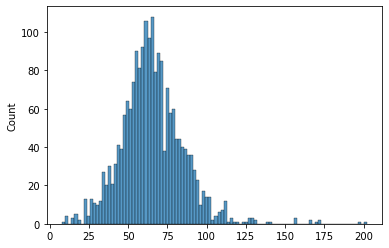

In [17]:
#Title lengths
t = []
for i in df['title_clean']:
  t.append(len(i))
sns.histplot(t,bins = 100)
plt.show()

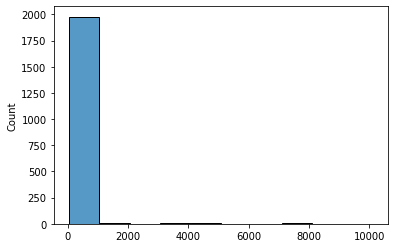

The mode of lengths of the paragraph is: 150
The median of lengths of the paragraph is: 155.0
The mean of lengths of the paragraph is: 223.2155


In [18]:
#Paragraph lengths
p = []
for i in df['paragraph_clean']:
  p.append(len(i))
sns.histplot(p,bins = 10)
plt.show()

print('The mode of lengths of the paragraph is:', mode(p))
print('The median of lengths of the paragraph is:', median(p))
print('The mean of lengths of the paragraph is:', mean(p))

Two different sentences. Titles and paragraphs. Pass two seperate sentences and seperate them using [SEP] token. Pass two sentences seperately in the BERT tokenizer.

In [19]:
def get_top_n_words(corpus, n=None):
    """
    List the top n words (unigrams) in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [20]:
df_sm = df[df['news_list']=='["Supplier Market"]']
df_fh = df[df['news_list']=='["Financial Health"]']
df_env = df[df['news_list']=='["Environmental"]']
df_comm = df[df['news_list']=='["Commodities"]']
df_d = df[df['news_list']=='["Delays"]']
df_comp = df[df['news_list']=='["Compliance"]']

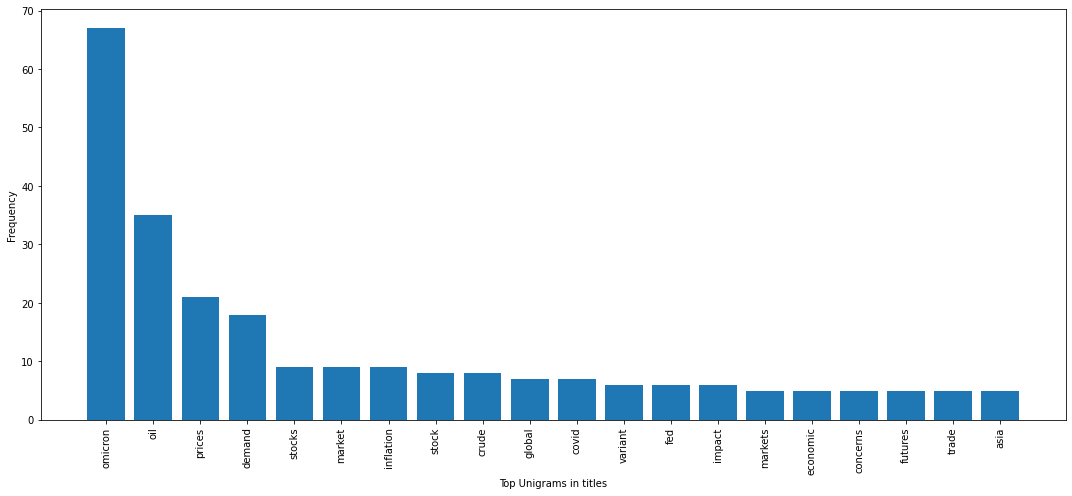

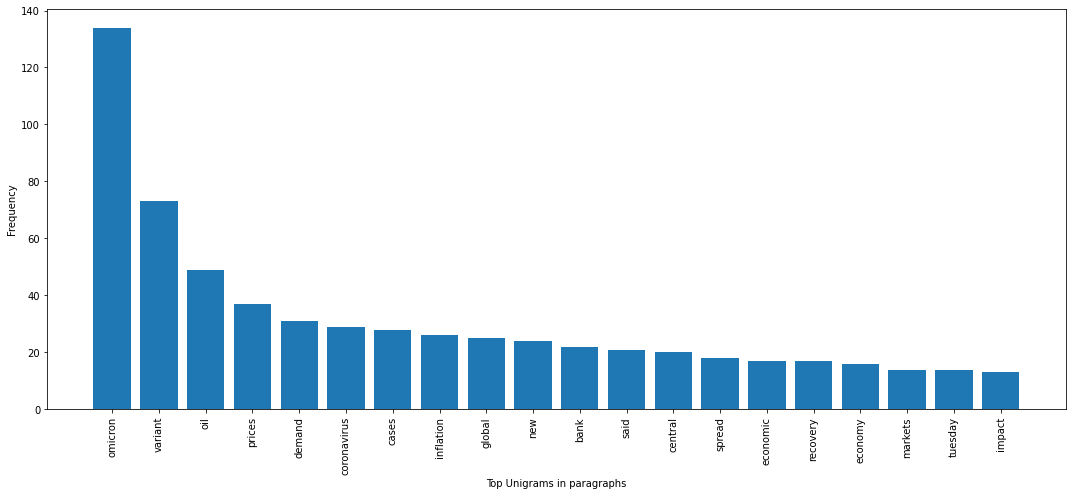

In [21]:
smt = get_top_n_words(df_sm['title_clean'],n=20)
smp = get_top_n_words(df_sm['paragraph_clean'],n=20)
indt = []
fret = []
for item in smt:
   indt.append(item[0])
   fret.append(item[1])

indp = []
frep = []
for item in smp:
   indp.append(item[0])
   frep.append(item[1])

plt.rcParams["figure.figsize"] = [15, 7]
plt.rcParams["figure.autolayout"] = True
plt.bar(indt,fret)
# plt.bar(indp,frep)
plt.xlabel('Top Unigrams in titles')
plt.ylabel('Frequency')
plt.xticks(rotation = 90)
plt.show()


plt.rcParams["figure.figsize"] = [15, 7]
plt.rcParams["figure.autolayout"] = True
#plt.bar(indt,fret)
plt.bar(indp,frep)
plt.xlabel('Top Unigrams in paragraphs')
plt.ylabel('Frequency')
plt.xticks(rotation = 90)
plt.show()

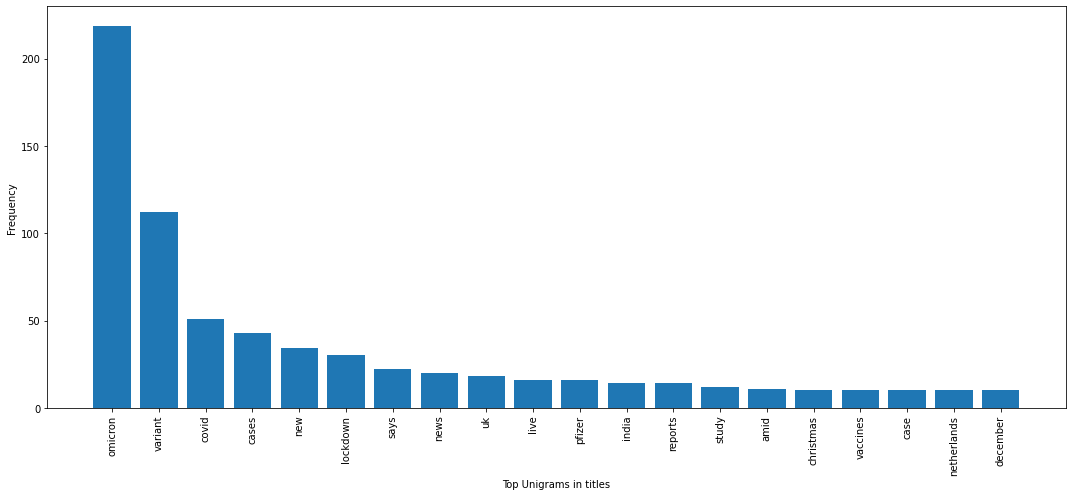

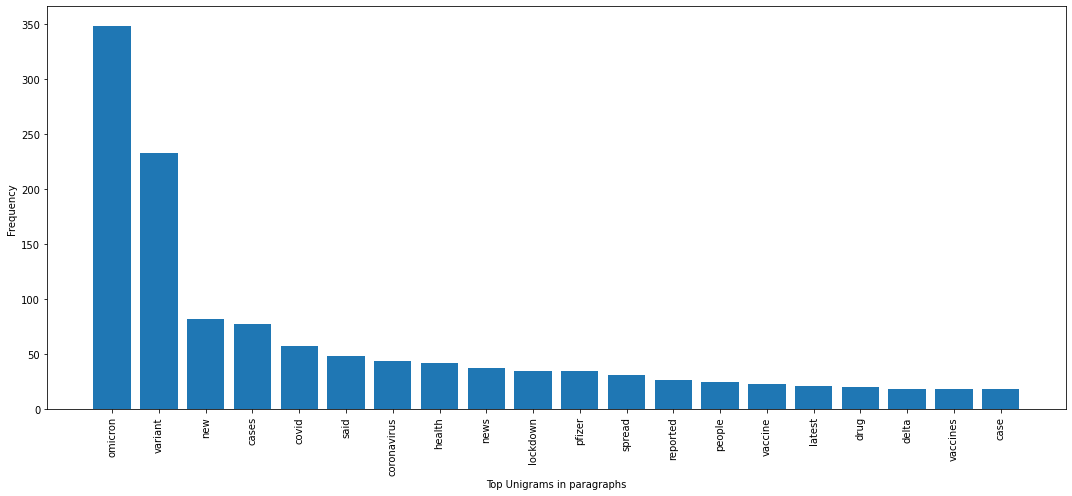

In [22]:
fht = get_top_n_words(df_fh['title_clean'],n=20)
fhp = get_top_n_words(df_fh['paragraph_clean'],n=20)
indt = []
fret = []
for item in fht:
   indt.append(item[0])
   fret.append(item[1])

indp = []
frep = []
for item in fhp:
   indp.append(item[0])
   frep.append(item[1])

plt.rcParams["figure.figsize"] = [15, 7]
plt.rcParams["figure.autolayout"] = True
plt.bar(indt,fret)
# plt.bar(indp,frep)
plt.xlabel('Top Unigrams in titles')
plt.ylabel('Frequency')
plt.xticks(rotation = 90)
plt.show()


plt.rcParams["figure.figsize"] = [15, 7]
plt.rcParams["figure.autolayout"] = True
#plt.bar(indt,fret)
plt.bar(indp,frep)
plt.xlabel('Top Unigrams in paragraphs')
plt.ylabel('Frequency')
plt.xticks(rotation = 90)
plt.show()

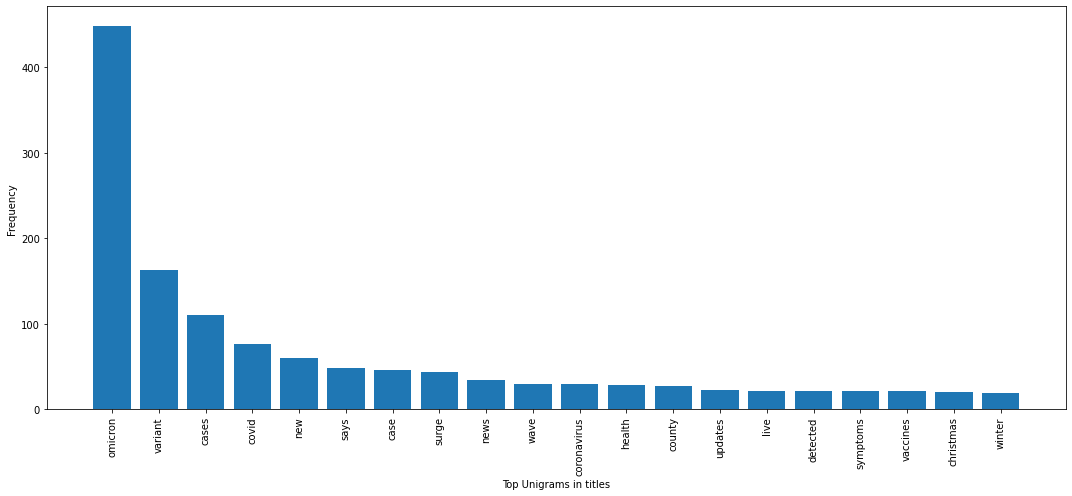

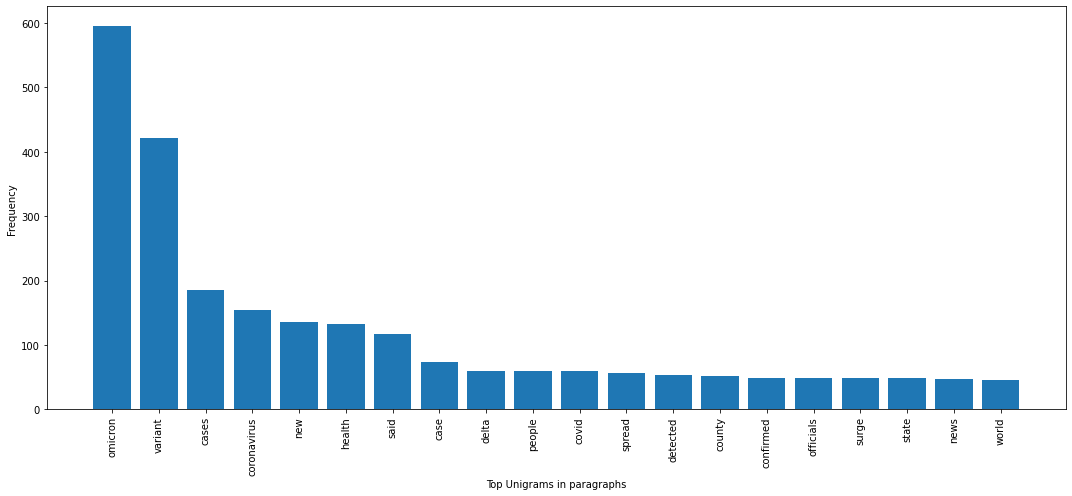

In [23]:
envt = get_top_n_words(df_env['title_clean'],n=20)
envp = get_top_n_words(df_env['paragraph_clean'],n=20)
indt = []
fret = []
for item in envt:
   indt.append(item[0])
   fret.append(item[1])

indp = []
frep = []
for item in envp:
   indp.append(item[0])
   frep.append(item[1])

plt.rcParams["figure.figsize"] = [15, 7]
plt.rcParams["figure.autolayout"] = True
plt.bar(indt,fret)
# plt.bar(indp,frep)
plt.xlabel('Top Unigrams in titles')
plt.ylabel('Frequency')
plt.xticks(rotation = 90)
plt.show()


plt.rcParams["figure.figsize"] = [15, 7]
plt.rcParams["figure.autolayout"] = True
#plt.bar(indt,fret)
plt.bar(indp,frep)
plt.xlabel('Top Unigrams in paragraphs')
plt.ylabel('Frequency')
plt.xticks(rotation = 90)
plt.show()

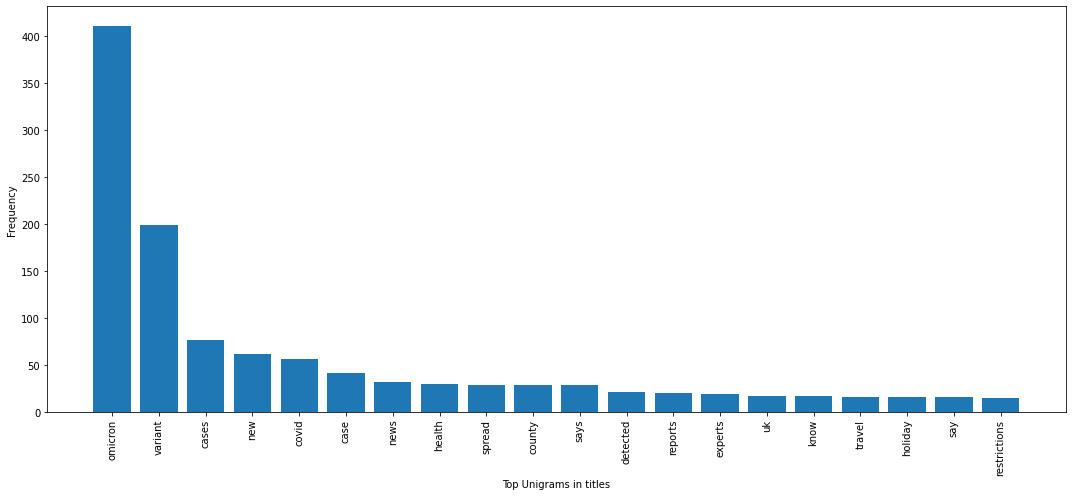

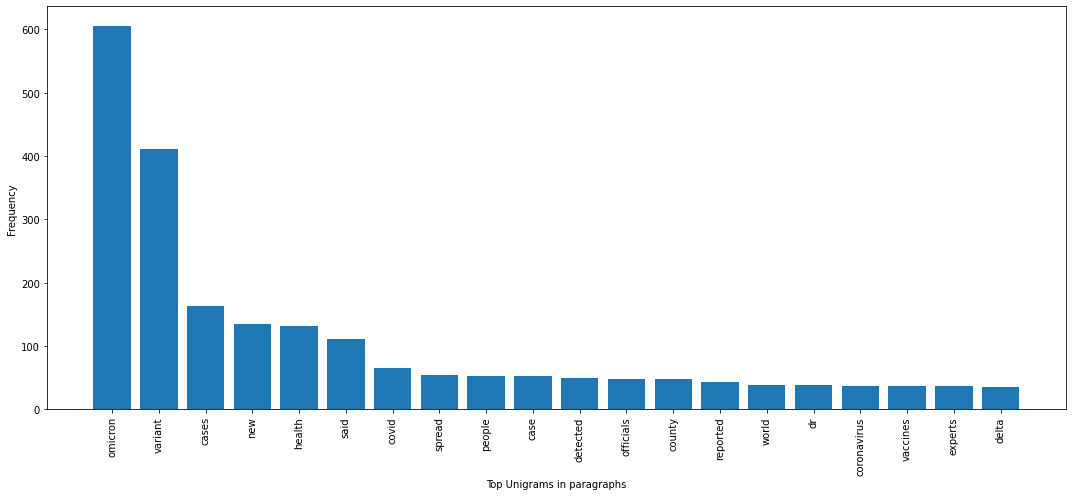

In [24]:
commt = get_top_n_words(df_comm['title_clean'],n=20)
commp = get_top_n_words(df_comm['paragraph_clean'],n=20)
indt = []
fret = []
for item in commt:
   indt.append(item[0])
   fret.append(item[1])

indp = []
frep = []
for item in commp:
   indp.append(item[0])
   frep.append(item[1])

plt.rcParams["figure.figsize"] = [15, 7]
plt.rcParams["figure.autolayout"] = True
plt.bar(indt,fret)
# plt.bar(indp,frep)
plt.xlabel('Top Unigrams in titles')
plt.ylabel('Frequency')
plt.xticks(rotation = 90)
plt.show()


plt.rcParams["figure.figsize"] = [15, 7]
plt.rcParams["figure.autolayout"] = True
#plt.bar(indt,fret)
plt.bar(indp,frep)
plt.xlabel('Top Unigrams in paragraphs')
plt.ylabel('Frequency')
plt.xticks(rotation = 90)
plt.show()

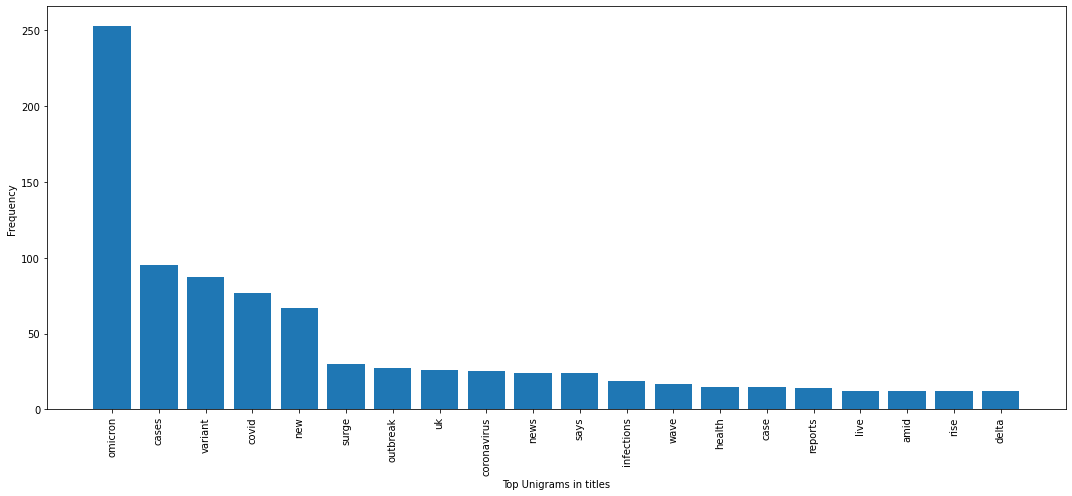

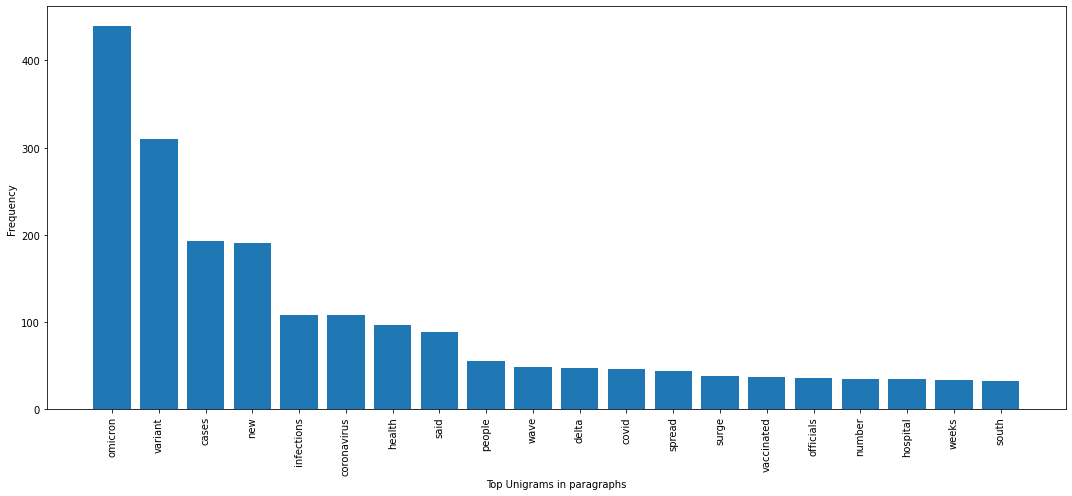

In [25]:
dt = get_top_n_words(df_d['title_clean'],n=20)
dp = get_top_n_words(df_d['paragraph_clean'],n=20)
indt = []
fret = []
for item in dt:
   indt.append(item[0])
   fret.append(item[1])

indp = []
frep = []
for item in dp:
   indp.append(item[0])
   frep.append(item[1])

plt.rcParams["figure.figsize"] = [15, 7]
plt.rcParams["figure.autolayout"] = True
plt.bar(indt,fret)
# plt.bar(indp,frep)
plt.xlabel('Top Unigrams in titles')
plt.ylabel('Frequency')
plt.xticks(rotation = 90)
plt.show()


plt.rcParams["figure.figsize"] = [15, 7]
plt.rcParams["figure.autolayout"] = True
#plt.bar(indt,fret)
plt.bar(indp,frep)
plt.xlabel('Top Unigrams in paragraphs')
plt.ylabel('Frequency')
plt.xticks(rotation = 90)
plt.show()

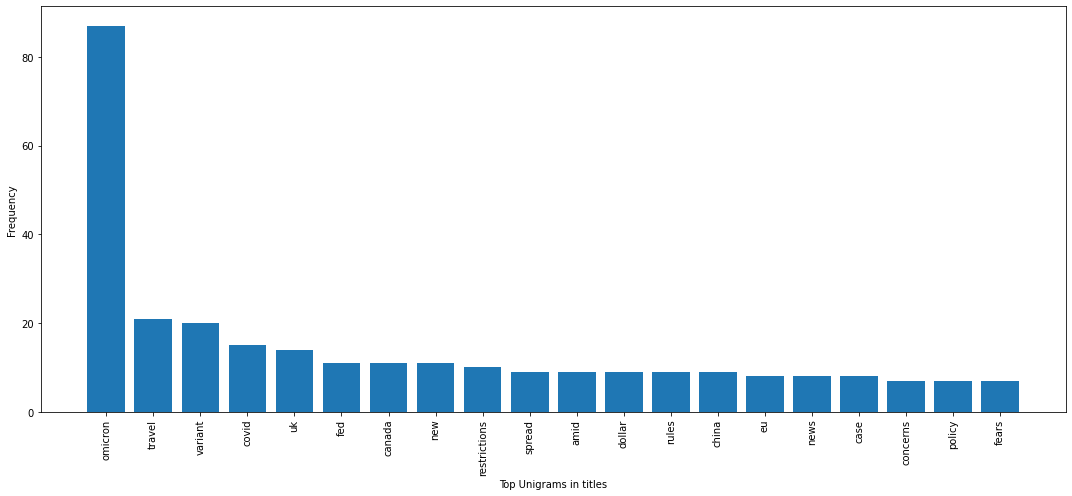

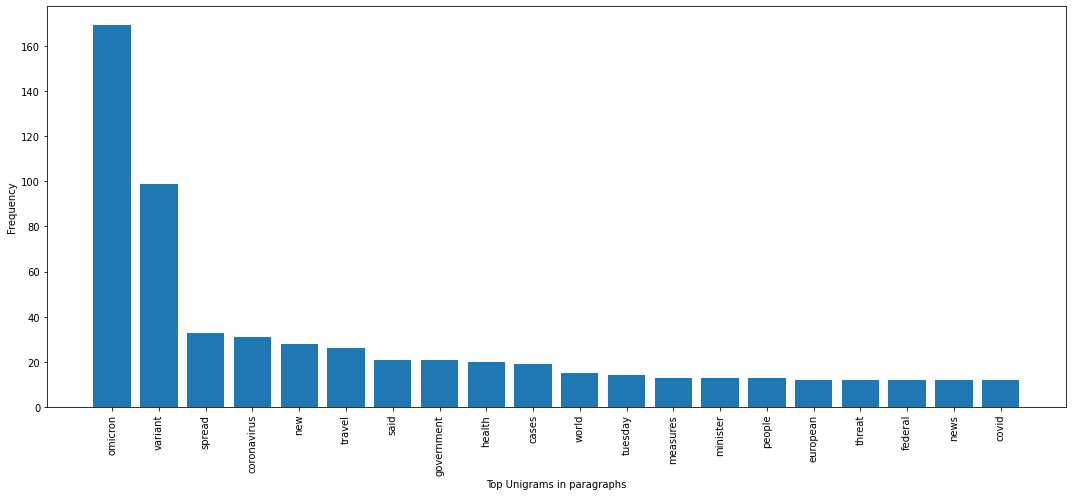

In [26]:
compt = get_top_n_words(df_comp['title_clean'],n=20)
compp = get_top_n_words(df_comp['paragraph_clean'],n=20)
indt = []
fret = []
for item in compt:
   indt.append(item[0])
   fret.append(item[1])

indp = []
frep = []
for item in compp:
   indp.append(item[0])
   frep.append(item[1])

plt.rcParams["figure.figsize"] = [15, 7]
plt.rcParams["figure.autolayout"] = True
plt.bar(indt,fret)
# plt.bar(indp,frep)
plt.xlabel('Top Unigrams in titles')
plt.ylabel('Frequency')
plt.xticks(rotation = 90)
plt.show()


plt.rcParams["figure.figsize"] = [15, 7]
plt.rcParams["figure.autolayout"] = True
#plt.bar(indt,fret)
plt.bar(indp,frep)
plt.xlabel('Top Unigrams in paragraphs')
plt.ylabel('Frequency')
plt.xticks(rotation = 90)
plt.show()

In [27]:
df.columns

Index(['title', 'paragraph', 'news_list', 'event_timestamp',
       'news_list_encoded', 'title_clean', 'paragraph_clean'],
      dtype='object')

In [28]:
df_final = df[['title_clean','paragraph_clean','news_list_encoded']]

In [29]:
df_final.head()

,title_clean,paragraph_clean,news_list_encoded
0,will the grinch cancel a santa rally on the st...,opinion stock markets typically trade higher a...,5
1,spdr sp xop etf in a multiyear uptrend buy the...,spdr sp oil gas exploration production etf xop...,4
2,britain reports new omicron cases major incide...,the total number of omicron cases recorded acr...,3
3,risk aversion sentiment continues to percolate,risk aversion sentiment on rapid spread of the...,0
4,omicron rush on boosters may make it harder to...,countries are saying three vaccine doses are n...,0


In [30]:
train_df,val_df = train_test_split(df_final,random_state = 42,test_size=0.2)

In [31]:
print(train_df.shape)
print(val_df.shape)

(1600, 3)
(400, 3)


In [32]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
print(train_dataset)
print(val_dataset)

Dataset({
    features: ['title_clean', 'paragraph_clean', 'news_list_encoded', '__index_level_0__'],
    num_rows: 1600
})
Dataset({
    features: ['title_clean', 'paragraph_clean', 'news_list_encoded', '__index_level_0__'],
    num_rows: 400
})


In [33]:
train_dataset = train_dataset.remove_columns(['__index_level_0__'])
val_dataset = val_dataset.remove_columns(['__index_level_0__'])

In [34]:
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [35]:
tokenizer.pad_token_id

0

In [36]:
def tokenize_funct(df):
  return tokenizer(df["title_clean"], df["paragraph_clean"], truncation=True,padding = 'max_length',max_length = 150)
train_tokenized_datasets = train_dataset.map(tokenize_funct, batched=True)
val_tokenized_datasets = val_dataset.map(tokenize_funct, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [37]:
len(val_tokenized_datasets['news_list_encoded'])

400

In [38]:
tf_train_dataset = train_tokenized_datasets.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["news_list_encoded"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=32,
)

tf_validation_dataset = val_tokenized_datasets.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["news_list_encoded"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=32,
)

In [39]:
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=cat)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
optim = tf.keras.optimizers.Adam(
    learning_rate=3e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam',
)
model.compile(
    optimizer=optim,
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    epochs = 10
)

Epoch 1/10
50/50 [==============================] - 114s 2s/step - loss: 1.7079 - accuracy: 0.2488 - val_loss: 1.7054 - val_accuracy: 0.2475
Epoch 2/10
50/50 [==============================] - 92s 2s/step - loss: 1.7037 - accuracy: 0.2294 - val_loss: 1.7376 - val_accuracy: 0.2475
Epoch 3/10
50/50 [==============================] - 92s 2s/step - loss: 1.6882 - accuracy: 0.2400 - val_loss: 1.7060 - val_accuracy: 0.2975
Epoch 4/10
50/50 [==============================] - 92s 2s/step - loss: 1.6808 - accuracy: 0.2637 - val_loss: 1.7363 - val_accuracy: 0.2975
Epoch 5/10
50/50 [==============================] - 92s 2s/step - loss: 1.6913 - accuracy: 0.2562 - val_loss: 1.7483 - val_accuracy: 0.2975
Epoch 6/10
50/50 [==============================] - 92s 2s/step - loss: 1.6960 - accuracy: 0.2531 - val_loss: 1.7016 - val_accuracy: 0.2975
Epoch 7/10
50/50 [==============================] - 92s 2s/step - loss: 1.6963 - accuracy: 0.2406 - val_loss: 1.7161 - val_accuracy: 0.2975
Epoch 8/10
50/50 [=

In [48]:
preds = model.predict(tf_validation_dataset)["logits"]
class_preds = np.argmax(preds, axis=1)
class_preds[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

**The dataset is imbalanced. So, accuracy is not a good evaluation metric. Hence, we should calculate the F1-score. **

In [49]:
print(classification_report(val_dataset['news_list_encoded'],class_preds))

              precision    recall  f1-score   support

           0       0.25      1.00      0.40        99
           1       0.00      0.00      0.00        43
           2       0.00      0.00      0.00        69
           3       0.00      0.00      0.00       119
           4       0.00      0.00      0.00        39
           5       0.00      0.00      0.00        31

    accuracy                           0.25       400
   macro avg       0.04      0.17      0.07       400
weighted avg       0.06      0.25      0.10       400



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


** The F1 score is less because of low training done. Following ways can be used for improving the performance of the model:
1. Train for longer duration.
2. Take into acount the imbalance in the dataset.
3. Hyperparameter tuning
4. Tune the maximum inout length according to the data.
5. Use more data to train the model.
6. Use a Different architecture. **

Q. How would you collect such data from the internet?

Data can be collected using web scrapping and making web scrappers for automated data extraction.